# Set-Up

In [ ]:
!sudo apt install tesseract-ocr
!pip install -q pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install -q datasets seqeval

In [ ]:
!pip install accelerate -U

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-xqxh30x5
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-xqxh30x5
  Resolved https://github.com/facebookresearch/detectron2.git to commit 5de5319a49e7ea819586d3d6a817632392dfdeb2
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install pdf2image
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from PIL import Image, ImageDraw
import json
import os
import datasets
from pdf2image import convert_from_path

# Data Extraction from Annotations

In [ ]:
# extending old annotations with new
ann_1 = Path('/content/drive/MyDrive/receipt_dataset/annotation_results.json')
ann_2 = Path('/content/drive/MyDrive/receipt_dataset/new_labels.json')

files=[ann_1, ann_2]

def merge_JsonFiles(json_files, res_json_path):
    result = list()
    for f1 in json_files:
        with open(f1, 'r') as infile:
            result.extend(json.load(infile))

    with open(res_json_path, 'w') as output_file:
        json.dump(result, output_file)

merge_JsonFiles(files, Path('/content/drive/MyDrive/receipt_dataset/all_annotations.json'))

In [ ]:
annotation_path = Path('/content/drive/MyDrive/receipt_dataset/all_annotations.json')

with open(annotation_path, 'r') as annotation_f:
  annotation_list = json.load(annotation_f)

type(annotation_list)

list

In [ ]:
labels = ['O', 'B-COMPANY', 'I-COMPANY', 'B-DATE', 'I-DATE', 'B-ADDRESS',
          'I-ADDRESS', 'B-TOTAL', 'I-TOTAL']

id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}
label2id

{'O': 0,
 'B-COMPANY': 1,
 'I-COMPANY': 2,
 'B-DATE': 3,
 'I-DATE': 4,
 'B-ADDRESS': 5,
 'I-ADDRESS': 6,
 'B-TOTAL': 7,
 'I-TOTAL': 8}

In [ ]:
# converts ls normalized boxes to pixels, returns coord. for top-left and bottom-right

def unnormalize_box(result):
  value = result['value']
  w, h = result['original_width'], result['original_height']

  if all([key in value for key in ['x', 'y', 'width', 'height']]):
    x0, y0 = w * value['x'] / 100.0, h * value['y'] / 100.0
    x1, y1 = x0 + w * value['width'] / 100.0, y0 + h * value['height'] / 100.0
    return [x0, y0, x1, y1]

In [ ]:
# gets formatted data from ls json file for 1 task
# ex = {image: [...], words: [...], boxes: [...], ner_tags: [...]}

def get_some_formatted(receipt_ann, ds_path, label2id):
  formatted_ex = {}

  image_name = receipt_ann['data']['ocr'].split('%5C')[1]

  # костыльчик, чтобы можно было юзать функцию с общей аннотацией на датасеты с разным путем
  if os.path.exists(os.path.join(ds_path, image_name)):
    image_np = np.array(Image.open(os.path.join(ds_path, image_name)))
    formatted_ex['image'] = image_np

    formatted_ex['words'] = [ann['value']['text'] for ann in receipt_ann['annotations'][0]['result'] if ann['type'] == 'textarea']
    formatted_ex['words'] = np.squeeze(np.array(formatted_ex['words']))


    formatted_ex['boxes'] = np.array([unnormalize_box(ann) for ann in receipt_ann['annotations'][0]['result'] if ann['type'] == 'rectangle'], dtype=np.uint32)

    formatted_ex['ner_tags'] = [label2id[ann['value']['labels'][0]] for ann in receipt_ann['annotations'][0]['result'] if ann['type'] == 'labels']
    formatted_ex['ner_tags'] = np.squeeze(np.array(formatted_ex['ner_tags']))

    return formatted_ex

In [ ]:
# checking result shapes after formatting

example_ = annotation_list[0]

image_ds_path = Path('/content/drive/MyDrive/receipt_dataset/train')
example_cleared = get_some_formatted(example_, image_ds_path, label2id)

print(example_cleared['image'].shape, example_cleared['words'].shape,
      example_cleared['boxes'].shape, example_cleared['ner_tags'].shape)

(3724, 1584, 3) (111,) (111, 4) (111,)


In [ ]:
# getting dataset of all examples

test_image_ds_path = Path('/content/drive/MyDrive/receipt_dataset/test')

train_dataset = []
test_dataset = []

for receipt_data in annotation_list:
  train_dataset.append(get_some_formatted(receipt_data, ds_path=image_ds_path, label2id=label2id))
  test_dataset.append(get_some_formatted(receipt_data, ds_path=test_image_ds_path, label2id=label2id))

# ahhhhhwhareee
train_dataset = [ex for ex in train_dataset if ex != None]
test_dataset = [ex for ex in test_dataset if ex != None]

print(len(train_dataset))
print(len(test_dataset))

58
5


In [ ]:
# model accepts boxes in range 0..1000 xd

def normalize_box_1000(box, height, width):

  x0, y0, x2, y2 = [int(p) for p in box]

  x0 = int(1000 * (x0 / width))
  x2 = int(1000 * (x2 / width))
  y0 = int(1000 * (y0 / height))
  y2 = int(1000 * (y2 / height))

  return [x0, y0, x2, y2]

In [ ]:
def normalize_boxes_of_data(data):
  hw = data['image'].shape
  for i, box in enumerate(data['boxes']):
    norm_box = normalize_box_1000(box, hw[0], hw[1])
    data['boxes'][i] = norm_box

In [ ]:
for data in train_dataset:
  normalize_boxes_of_data(data)

for data in test_dataset:
  normalize_boxes_of_data(data)

In [ ]:
# image 33 is portraited phone picture, and I can't rearrange it, so pop that punk
train_dataset.pop(33)
print(len(train_dataset))

57


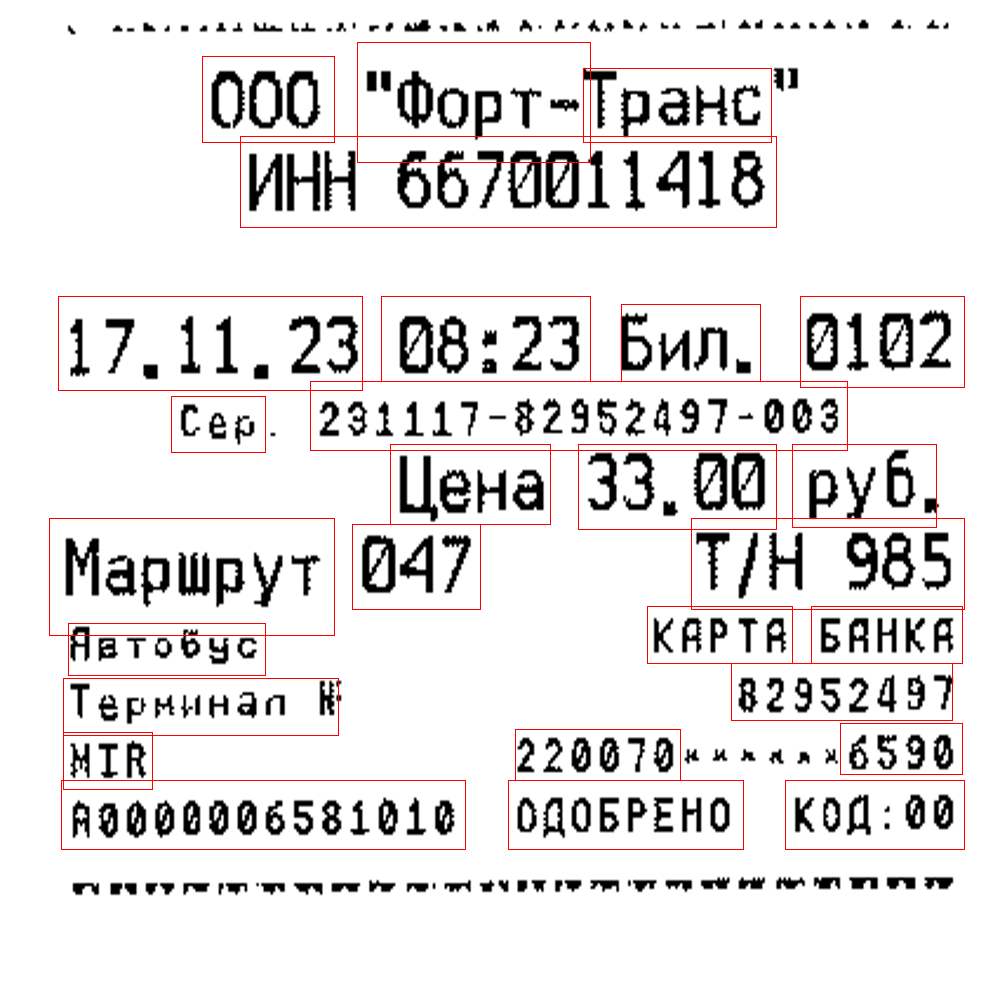

In [ ]:
example = test_dataset[1]
image = Image.fromarray(example['image']).resize((1000, 1000))
image_draw = ImageDraw.Draw(image)

for box in example['boxes']:
  image_draw.rectangle([box[0], box[1], box[2], box[3]], outline='red')

image

# Train Dataset Preparation ..zZz..

In [ ]:
labels = ['O', 'B-COMPANY', 'I-COMPANY', 'B-DATE', 'I-DATE', 'B-ADDRESS',
          'I-ADDRESS', 'B-TOTAL', 'I-TOTAL']

id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}
label2id

{'O': 0,
 'B-COMPANY': 1,
 'I-COMPANY': 2,
 'B-DATE': 3,
 'I-DATE': 4,
 'B-ADDRESS': 5,
 'I-ADDRESS': 6,
 'B-TOTAL': 7,
 'I-TOTAL': 8}

In [ ]:
# copying datasets, but I don't really know why lol
train_ds_copy = train_dataset.copy()
test_ds_copy = test_dataset.copy()

In [ ]:
# adding third dimension for grayscale images
def get_third_dim(ds_image):
  return np.dstack((ds_image, ds_image, ds_image))

# removing fourth dimension for some png images
def remove_fourth_dim(ds_image):
  return ds_image[:,:,:3]

for i, ex in enumerate(train_ds_copy):
  if len(ex['image'].shape) == 2:
    print(i)
    train_ds_copy[i]['image'] = get_third_dim(train_ds_copy[i]['image'])
    print(f"after adding: {train_ds_copy[i]['image'].shape}")

for i, ex in enumerate(test_ds_copy):
  if len(ex['image'].shape) == 2:
    print(i)
    test_ds_copy[i]['image'] = get_third_dim(test_ds_copy[i]['image'])
    print(f"after adding: {test_ds_copy[i]['image'].shape}")

47
after adding: (2339, 1653, 3)


In [ ]:
for i, ex in enumerate(train_ds_copy):
  if ex['image'].shape[2] == 4:
    print(i)
    train_ds_copy[i]['image'] = remove_fourth_dim(train_ds_copy[i]['image'])
    print(f"after removing: {train_ds_copy[i]['image'].shape}")

for i, ex in enumerate(test_ds_copy):
  if ex['image'].shape[2] == 4:
    print(i)
    test_ds_copy[i]['image'] = remove_fourth_dim(test_ds_copy[i]['image'])
    print(f"after removing: {test_ds_copy[i]['image'].shape}")

48
after removing: (1264, 1507, 3)


In [ ]:
# flatten data before casting to dataframe
def some_stuff(dataset):
  ds_copy = dataset.copy()

  for i in range(len(dataset)):
    for key, value in dataset[i].items():
      print(key, value)
      ds_copy[i][key] = value.flatten()

  return (ds_copy, 'naming god')

In [ ]:
# adding 'image_shape' field for retrieving original shape later

for i in range(len(train_dataset)):
  train_ds_copy[i]['image_shape_h_w_d'] = list(train_dataset[i]['image'].shape)

for i in range(len(test_dataset)):
  test_ds_copy[i]['image_shape_h_w_d'] = list(test_dataset[i]['image'].shape)

In [ ]:
train_ds_copy[0]['image_shape_h_w_d'], test_ds_copy[0]['image_shape_h_w_d']

([3724, 1584, 3], [924, 671, 3])

In [ ]:
def flat_ds_data(ds):
  ds_copy = ds.copy()

  for i in range(len(ds)):
    for key, value in ds[i].items():
      if isinstance(value, np.ndarray):
        ds_copy[i][key] = ds_copy[i][key].flatten()
      ds_copy[i][key] = np.asarray(ds_copy[i][key])

  return ds_copy

In [ ]:
train_flatten_ds = flat_ds_data(train_ds_copy)
test_flatten_ds = flat_ds_data(test_ds_copy)

for key, value in test_flatten_ds[3].items():
  print(key, value)

image [255 255 255 ... 246 248 252]
words ['Общество' 'ограниченной' 'ответственностью' 'Диджитал' 'Лаб"' 'ИНН:'
 '9717073792' 'https://immers.cloud' '109316' 'Регион 77' 'Москва'
 'Волгоградский' 'проспект' 'корпус 9' 'Кассовый чек' 'Приход' 'Смена'
 'ККТ007122' 'Чек №:' 'интернет' '25.10.2023' 'Наименование' 'Цена'
 'Сумма' 'Услуги' 'облачной' 'платформы' '200.00' 'immers.' 'cloud'
 'Платеж' 'Полный' 'расчет' 'Итог' 'стоимость' 'продажи' '200.00'
 'ИТОГО без' 'НДС' '200.00' 'ИТОГО:' '200,00' 'Предоплатой' 'зачетом'
 'аванса' 'ККТ:' '0004367937024586' '№ ФД:' '53642' 'ФН:'
 '9960440503290808' 'ФПД:' '3320314520' 'Версия' 'ФФД:' '1.05'
 'Налогообложение' 'Сайт' 'https://www.nalog.ru/rn77/' 'почта'
 'отправителя' 'payments@immera.' 'cloud' 'Телефон' 'почта' 'покупателя'
 'peter71302@gmail.com' 'СПАСИБО' 'с' 'Тек Энд' 'дом 42' '№: 423'
 '№ авт.:' 'ККТ для' '25' '08:30' 'за ед.' 'Кол.' '1.00' '200' '200.00'
 'РН' '№' 'ОСН' 'ФНС' 'Эл.' 'или эл.']
boxes [157  14 241  23 275  10 411  27 421 

In [ ]:
# converting list of dictionaries to transformers Dataset by using pandas df

train_df = pd.DataFrame.from_dict(train_flatten_ds)
test_df = pd.DataFrame.from_dict(test_flatten_ds)
print(type(test_df.iloc[0]['image']))

<class 'numpy.ndarray'>


In [ ]:
t_train_dataset = datasets.Dataset.from_pandas(train_df)
t_test_dataset = datasets.Dataset.from_pandas(test_df)

t_train_dataset, t_test_dataset

(Dataset({
     features: ['image', 'words', 'boxes', 'ner_tags', 'image_shape_h_w_d'],
     num_rows: 57
 }),
 Dataset({
     features: ['image', 'words', 'boxes', 'ner_tags', 'image_shape_h_w_d'],
     num_rows: 5
 }))

In [ ]:
# 92% train, 8% validation (my ds is smol)
# compiling into single DatasetDict
train_valid_dataset = datasets.DatasetDict({
    'train': t_train_dataset,
    'valid': t_test_dataset})

In [ ]:
train_valid_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'words', 'boxes', 'ner_tags', 'image_shape_h_w_d'],
        num_rows: 57
    })
    valid: Dataset({
        features: ['image', 'words', 'boxes', 'ner_tags', 'image_shape_h_w_d'],
        num_rows: 5
    })
})

In [ ]:
from transformers import LayoutXLMProcessor

processor = LayoutXLMProcessor.from_pretrained("microsoft/layoutxlm-base", apply_ocr=False)

In [ ]:
# func for Datasets.map(), handle multiple all rows at once

def prepare_examples(examples):
  # ugly aaaahhhhware
  h_ws, images, boxes, labels = [], [], [], []

  for shape in examples['image_shape_h_w_d']:
    h_ws.append(shape[:2])

  for i, image in enumerate(examples['image']):
    images.append(np.asarray(image).reshape(h_ws[i][0], h_ws[i][1], 3))

  words = examples['words']

  for box in examples['boxes']:
    boxes.append(np.asarray(box).reshape(-1, 4))

  for tags in examples['ner_tags']:
    labels.append(np.asarray(tags))

  encoding = processor(images, words, boxes=boxes, word_labels=labels,
                       truncation=True, padding="max_length", max_length=512)

  return encoding

In [ ]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

features = Features({
    'image': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

column_names = train_valid_dataset['train'].column_names

t_train_dataset = train_valid_dataset['train'].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

Map:   0%|          | 0/57 [00:00<?, ? examples/s]

In [ ]:
t_valid_dataset = train_valid_dataset['valid'].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

In [ ]:
t_train_dataset

Dataset({
    features: ['image', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 57
})

In [ ]:
t_valid_dataset

Dataset({
    features: ['image', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 5
})

In [ ]:
example = t_train_dataset[6]
processor.tokenizer.decode(example["input_ids"])

'<s> УРАЛСИБ БАНК ООО СмартВет VETERINARNAYA KLINIKA AS Г Новосибирск Ул. Шекспира Terminal 10 ; 32036997 ЧЕК N0512 ОПЛАТА СУММА (RUB) 2 900.00 КОМИССИЯ ЭКВАЙЕРА (RUB) ИТОГО (RUB) 2900,00 КАРТА 7469 KLIMOVE/SVETLANA AID: A989808983101 ОШОБРЕНО Код ОТВЕТА КОД АВТОРИЗАЦИИ 527896 ССЫЛКИ RRN Дата 21.10.17 13 : 31 : 25 ВВЕДЕН ПИН-КОД ПОДПИСЬ ТРЕБУЕТСЯ ПОДПИСЬ КАССИРА 00 Д. 10 visa 0,00 729401698093 Время КЛИЕНТА НЕ</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

In [ ]:
for id, label in zip(t_train_dataset[6]["input_ids"][:30], t_train_dataset[6]["labels"][:30]):
  print(processor.tokenizer.decode([id]), label)

<s> -100
У 0
РАЛ -100
СИ -100
Б -100
БАН 0
К -100
ООО 1
С -100
март -100
В -100
ет -100
V 2
ETER -100
INA -100
RN -100
AYA -100
 -100
KLI -100
NIKA -100
AS -100
Г 5
Новосибирск -100
Ул 6
. -100
Ше -100
к -100
спира -100
Terminal 0
10 0


In [ ]:
t_train_dataset.set_format("torch")

In [ ]:
# so fine
example = t_train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

image torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


# Define Metrics

In [ ]:
from datasets import load_metric

metric = load_metric("seqeval")

In [ ]:
label_list = ['O', 'B-COMPANY', 'I-COMPANY', 'B-DATE', 'I-DATE', 'B-ADDRESS', 'I-ADDRESS', 'B-TOTAL', 'I-TOTAL']

id2label

{0: 'O',
 1: 'B-COMPANY',
 2: 'I-COMPANY',
 3: 'B-DATE',
 4: 'I-DATE',
 5: 'B-ADDRESS',
 6: 'I-ADDRESS',
 7: 'B-TOTAL',
 8: 'I-TOTAL'}

In [ ]:
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

# Load XLM Model Checkpoint, Initialize Trainer

In [ ]:
from transformers import LayoutLMv2ForTokenClassification

model = LayoutLMv2ForTokenClassification.from_pretrained("/content/drive/MyDrive/layoutXLM_checkpoint",
                                                         id2label=id2label,
                                                         label2id=label2id,
                                                         num_labels=len(label_list))

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test",
                                  max_steps=250,
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=2,
                                  learning_rate=1e-5,
                                  evaluation_strategy="steps",
                                  eval_steps=10,
                                  logging_steps=50,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1")

In [ ]:
from transformers.data.data_collator import default_data_collator

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=t_train_dataset,
    eval_dataset=t_valid_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

# F1 score on purely SROIE fine-tuned checkpoint (92/8 split)

In [ ]:
# f1 is only 0.41 on small val set

trainer.evaluate()

{'eval_loss': 0.8122943639755249,
 'eval_precision': 0.6190476190476191,
 'eval_recall': 0.3170731707317073,
 'eval_f1': 0.4193548387096774,
 'eval_accuracy': 0.8706365503080082,
 'eval_runtime': 1.6135,
 'eval_samples_per_second': 3.099,
 'eval_steps_per_second': 1.859}

# F1 score purely SROIE fine-tuned checkpoint (old 60/40 split)

In [ ]:
t_train_dataset = datasets.Dataset.from_pandas(train_df)
t_test_dataset = datasets.Dataset.from_pandas(test_df)

full_t_dataset = datasets.concatenate_datasets([t_train_dataset, t_test_dataset])
full_t_dataset

Dataset({
    features: ['image', 'words', 'boxes', 'ner_tags', 'image_shape_h_w_d'],
    num_rows: 62
})

In [ ]:
# old 60% train, 40% validation
# compiling into single DatasetDict

t_train_valid_ds = full_t_dataset.train_test_split(test_size=0.4)

t_train_valid_ds

DatasetDict({
    train: Dataset({
        features: ['image', 'words', 'boxes', 'ner_tags', 'image_shape_h_w_d'],
        num_rows: 37
    })
    test: Dataset({
        features: ['image', 'words', 'boxes', 'ner_tags', 'image_shape_h_w_d'],
        num_rows: 25
    })
})

In [ ]:
t_train_dataset = t_train_valid_ds['train'].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

In [ ]:
t_valid_dataset = t_train_valid_ds['test'].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

In [ ]:
t_train_dataset.set_format("torch")

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=t_train_dataset,
    eval_dataset=t_valid_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.evaluate()

# f1 is only 0.37 on big val set

{'eval_loss': 0.6155585050582886,
 'eval_precision': 0.4634146341463415,
 'eval_recall': 0.3114754098360656,
 'eval_f1': 0.37254901960784315,
 'eval_accuracy': 0.8808625336927224,
 'eval_runtime': 3.2671,
 'eval_samples_per_second': 7.652,
 'eval_steps_per_second': 3.979}

# Train (92/8 split)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
10,No log,0.308792,0.656250,0.512195,0.575342,0.903491
20,No log,0.274984,0.567568,0.512195,0.538462,0.919918
30,No log,0.250369,0.676471,0.560976,0.613333,0.934292
40,No log,0.272865,0.694444,0.609756,0.649351,0.926078
50,0.253500,0.229768,0.684211,0.634146,0.658228,0.934292
60,0.253500,0.232194,0.722222,0.634146,0.675325,0.938398
70,0.253500,0.248049,0.684211,0.634146,0.658228,0.936345
80,0.253500,0.225763,0.764706,0.634146,0.693333,0.938398
90,0.253500,0.240993,0.710526,0.658537,0.683544,0.940452
100,0.130300,0.223397,0.771429,0.658537,0.710526,0.942505


TrainOutput(global_step=250, training_loss=0.10986459827423095, metrics={'train_runtime': 132.354, 'train_samples_per_second': 3.778, 'train_steps_per_second': 1.889, 'total_flos': 265613169364992.0, 'train_loss': 0.10986459827423095, 'epoch': 8.62})

In [ ]:
# saving this fine-tuned on rus receipts checkpoint to different place

trainer.save_model('/content/drive/MyDrive/layoutXLM_rus_trained')

# F1 score after training on russian dataset (92/8 split)

In [ ]:
model = LayoutLMv2ForTokenClassification.from_pretrained("/content/drive/MyDrive/layoutXLM_rus_trained")

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=t_train_dataset,
    eval_dataset=t_valid_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
# now f1 is 0.67, but it's only 5 examples

trainer.evaluate()

{'eval_loss': 0.2750996947288513,
 'eval_precision': 0.7027027027027027,
 'eval_recall': 0.6341463414634146,
 'eval_f1': 0.6666666666666667,
 'eval_accuracy': 0.944558521560575,
 'eval_runtime': 1.0214,
 'eval_samples_per_second': 4.895,
 'eval_steps_per_second': 2.937}

# F1 score after training on russian dataset (old 60/40 split)

In [ ]:
model = LayoutLMv2ForTokenClassification.from_pretrained("/content/drive/MyDrive/layoutXLM_rus_trained")

In [ ]:
t_train_dataset = datasets.Dataset.from_pandas(train_df)
t_test_dataset = datasets.Dataset.from_pandas(test_df)

full_t_dataset = datasets.concatenate_datasets([t_train_dataset, t_test_dataset])
full_t_dataset

Dataset({
    features: ['image', 'words', 'boxes', 'ner_tags', 'image_shape_h_w_d'],
    num_rows: 62
})

In [ ]:
# old 60% train, 40% validation
# compiling into single DatasetDict

t_train_valid_ds = t_train_dataset.train_test_split(test_size=0.4)

t_train_valid_ds

In [ ]:
t_train_dataset = t_train_valid_ds['train'].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

Map:   0%|          | 0/34 [00:00<?, ? examples/s]

In [ ]:
t_valid_dataset = t_train_valid_ds['test'].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

Map:   0%|          | 0/23 [00:00<?, ? examples/s]

In [ ]:
t_train_dataset.set_format("torch")

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=t_train_dataset,
    eval_dataset=t_valid_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
# 0.96 ??? Is that a miracle

# ooh because I've trained it with 92/8 split, so a lot of examples from val here
# was used for training too

trainer.evaluate()

{'eval_loss': 0.011014864780008793,
 'eval_precision': 0.9629629629629629,
 'eval_recall': 0.9629629629629629,
 'eval_f1': 0.9629629629629629,
 'eval_accuracy': 0.9966101694915255,
 'eval_runtime': 2.1052,
 'eval_samples_per_second': 10.925,
 'eval_steps_per_second': 5.7}

# True Inference on Russian Receipts (CLUELESS)


In [ ]:
from transformers import LayoutLMv2ForTokenClassification

model = LayoutLMv2ForTokenClassification.from_pretrained("/content/drive/MyDrive/layoutXLM_rus_trained")

In [ ]:
!sudo apt install tesseract-ocr-rus

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tesseract-ocr-rus
0 upgraded, 1 newly installed, 0 to remove and 11 not upgraded.
Need to get 1,271 kB of archives.
After this operation, 3,877 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-rus all 1:4.00~git30-7274cfa-1.1 [1,271 kB]
Fetched 1,271 kB in 1s (1,777 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tesseract-ocr-rus.
(Readin

In [ ]:
from transformers import LayoutXLMProcessor

# I can actually choose language for tess ocr
processor = LayoutXLMProcessor.from_pretrained("microsoft/layoutxlm-base", apply_ocr=True, ocr_lang='rus')

preprocessor_config.json:   0%|          | 0.00/135 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

config.4.13.0.json:   0%|          | 0.00/947 [00:00<?, ?B/s]

In [ ]:
processor.image_processor.__doc__

'\n    Constructs a LayoutLMv2 image processor.\n\n    Args:\n        do_resize (`bool`, *optional*, defaults to `True`):\n            Whether to resize the image\'s (height, width) dimensions to `(size["height"], size["width"])`. Can be\n            overridden by `do_resize` in `preprocess`.\n        size (`Dict[str, int]` *optional*, defaults to `{"height": 224, "width": 224}`):\n            Size of the image after resizing. Can be overridden by `size` in `preprocess`.\n        resample (`PILImageResampling`, *optional*, defaults to `Resampling.BILINEAR`):\n            Resampling filter to use if resizing the image. Can be overridden by the `resample` parameter in the\n            `preprocess` method.\n        apply_ocr (`bool`, *optional*, defaults to `True`):\n            Whether to apply the Tesseract OCR engine to get words + normalized bounding boxes. Can be overridden by\n            `apply_ocr` in `preprocess`.\n        ocr_lang (`str`, *optional*):\n            The language, 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device);

In [ ]:
# very weird new error with popller, fixed with this

!apt install poppler-utils -y
!apt-get install -y poppler-utils
!apt-get install -y poppler-utils --fix-missing

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.3 [186 kB]
Fetched 186 kB in 0s (1,842 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 120931 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.3_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.3) ...
Setting up poppler-utils (22.02.0-2ubuntu0.3) ...
Processing triggers for man-db (2.10.2-1) ...
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.3).
0 upgraded, 0 newly inst

In [ ]:
test_im = convert_from_path('/content/drive/MyDrive/receipt_dataset/cool_example.pdf')[0]

# don't forget to copy this to prototype pls
encoding = processor(test_im, return_offsets_mapping=True, return_tensors="pt",
                     truncation=True, padding='max_length', max_length=512)

offset_mapping = encoding.pop('offset_mapping')
print(encoding.keys())

dict_keys(['input_ids', 'attention_mask', 'bbox', 'image'])


In [ ]:
for k,v in encoding.items():
  encoding[k] = v.to(device)

In [ ]:
# forward pass
outputs = model(**encoding)
print(outputs.logits.shape)

torch.Size([1, 512, 9])


In [ ]:
def unnormalize_1000_box(bbox, width, height):
     return [
         int(width * (bbox[0] / 1000)),
         int(height * (bbox[1] / 1000)),
         int(width * (bbox[2] / 1000)),
         int(height * (bbox[3] / 1000)),
     ]

In [ ]:
predictions = outputs.logits.argmax(-1).squeeze().tolist()
token_boxes = encoding.bbox.squeeze().tolist()

width, height = test_im.size

In [ ]:
is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0

true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
true_boxes = [unnormalize_1000_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]

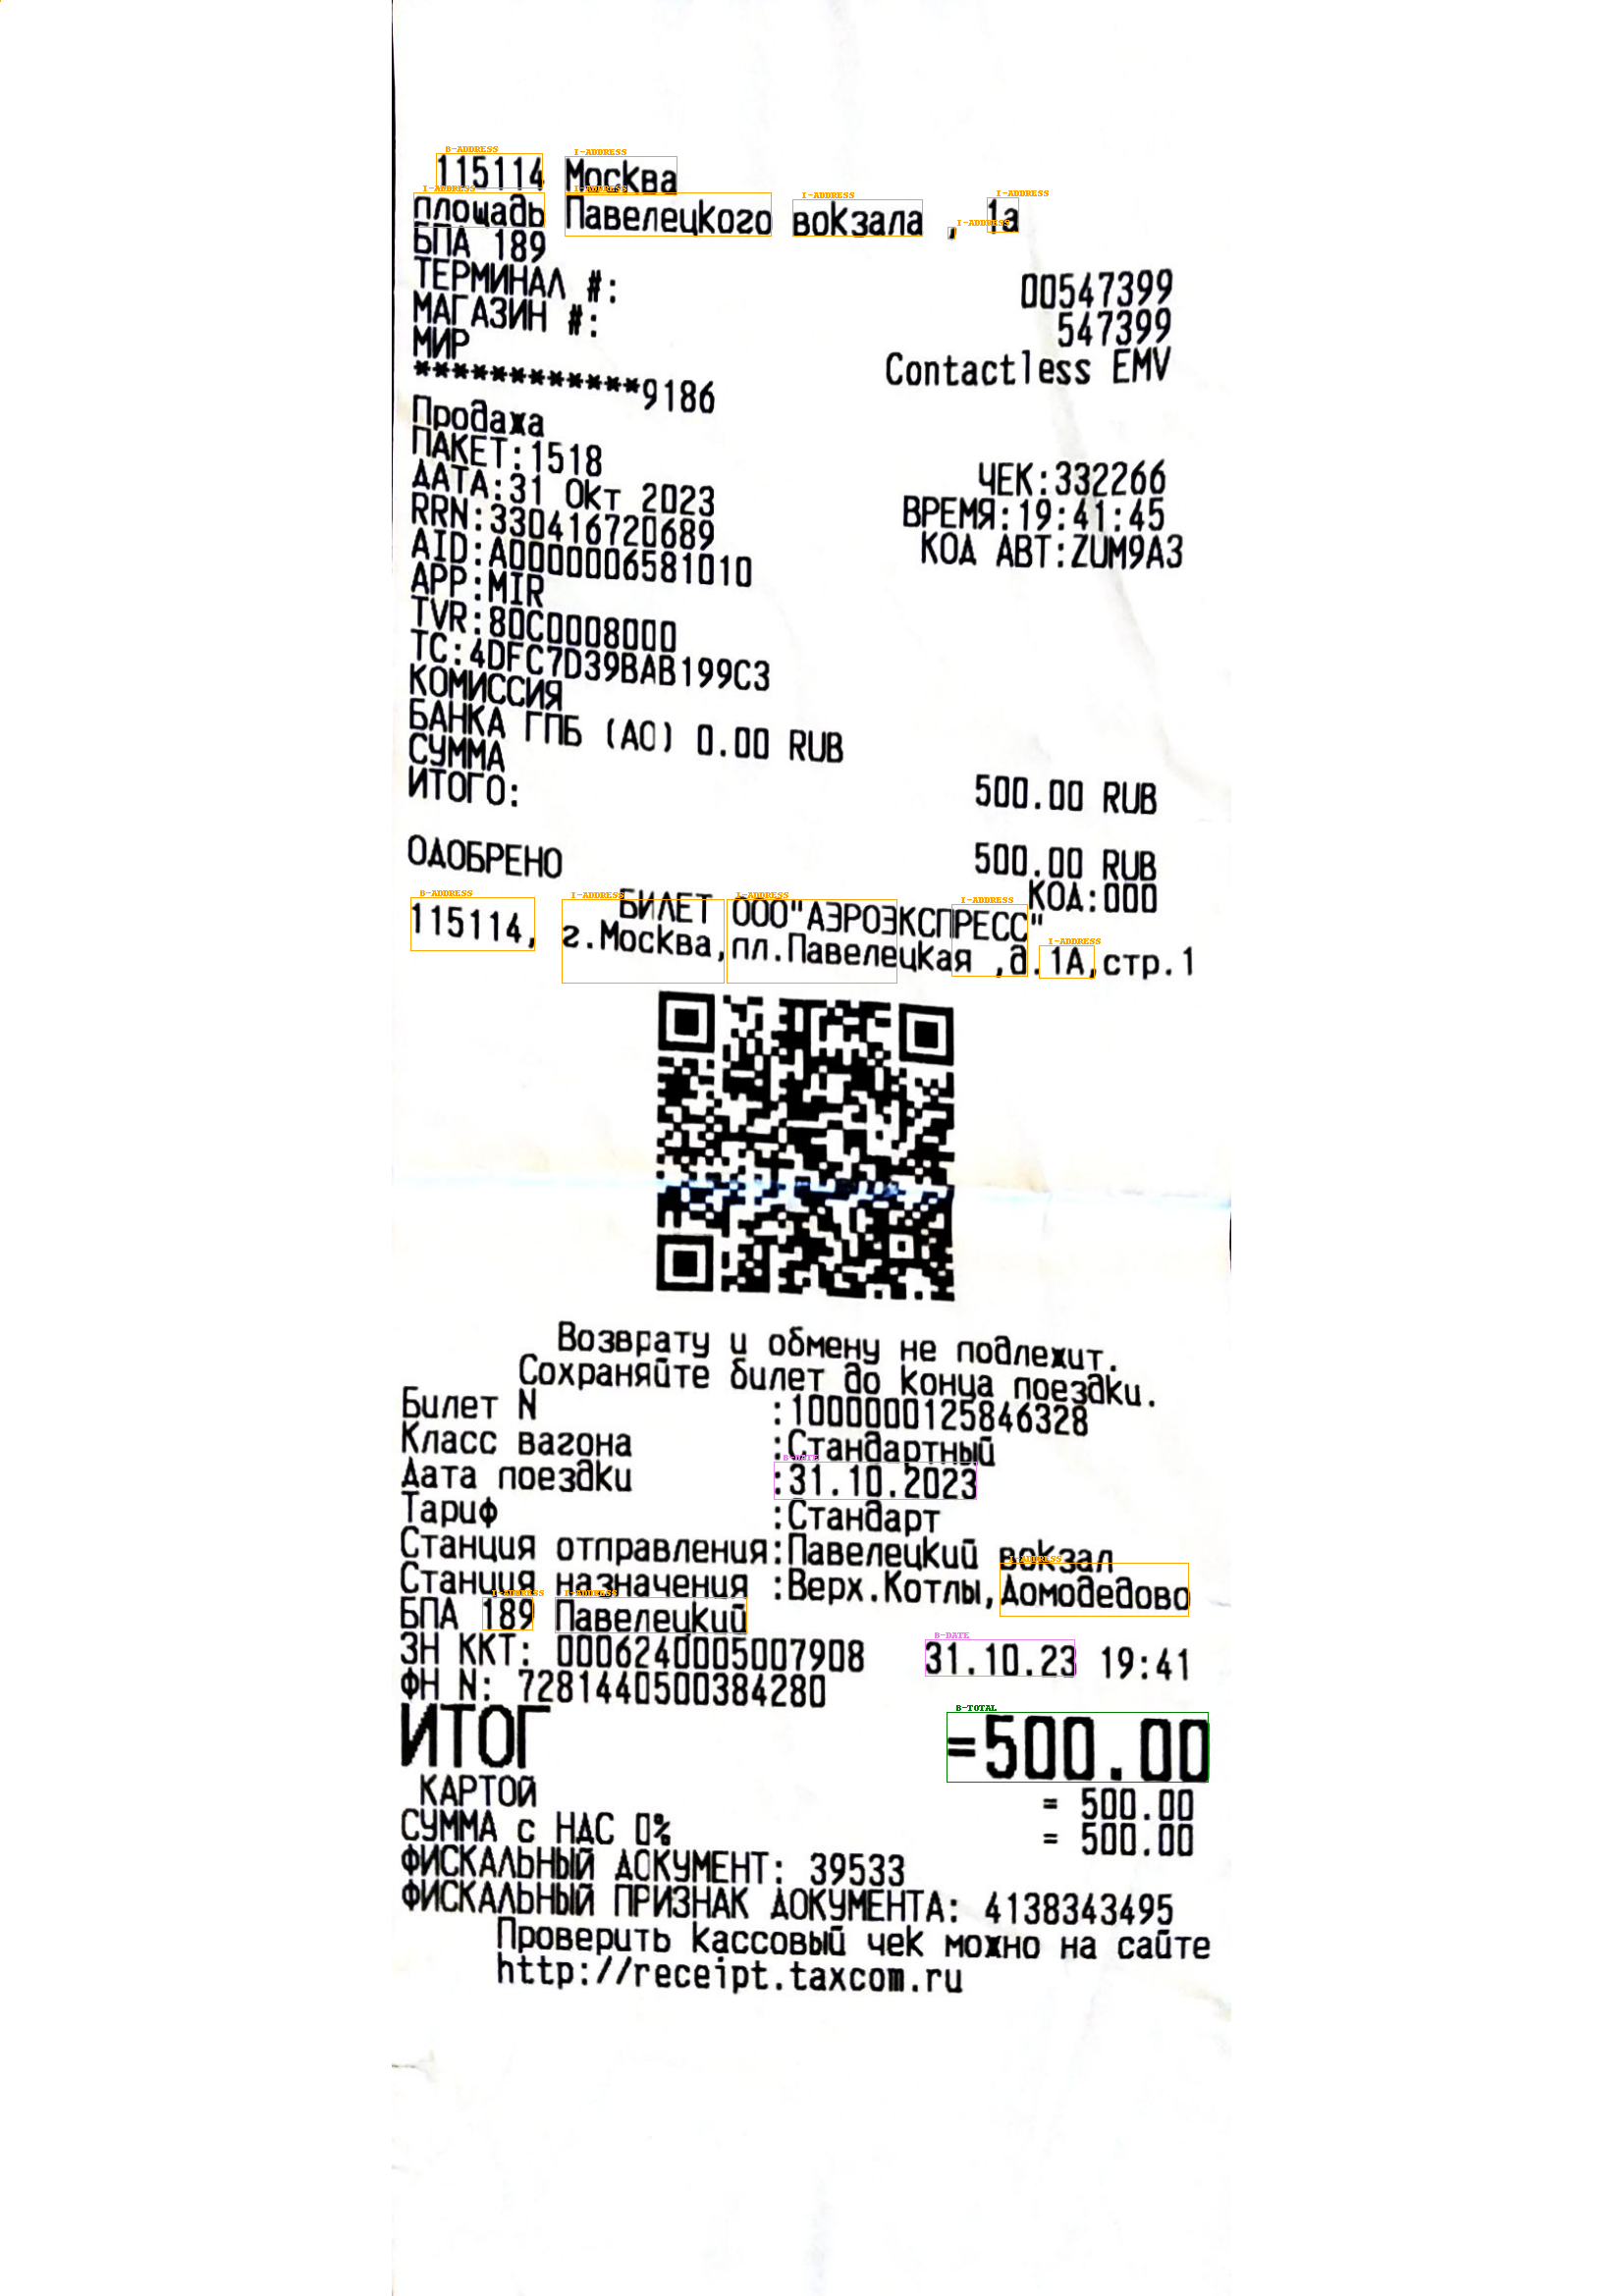

In [ ]:
draw = ImageDraw.Draw(test_im)

def iob_to_label(label):
    if not label:
      return 'O'
    return label

label2color = {'O':'gray', 'B-COMPANY':'red', 'I-COMPANY':'red', 'B-ADDRESS': 'orange',
               'I-ADDRESS': 'orange', 'B-DATE':'violet', 'I-DATE':'violet', 'B-TOTAL':'green', 'I-TOTAL':'green'}

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction)
    if predicted_label != 'O':
      draw.rectangle(box, outline=label2color[predicted_label])
      draw.text((box[0]+10, box[1]-10), text=predicted_label, fill=label2color[predicted_label])

test_im

# Retrieving Informative Tokens Text

In [ ]:

# len of boxes == len of input_ids == len of predictions
predictions = outputs.logits.argmax(-1).squeeze().tolist()
token_boxes = encoding.bbox.squeeze().tolist()
input_ids = encoding['input_ids'].squeeze().tolist()

print(len(predictions), len(token_boxes), len(input_ids))


512 512 512


In [ ]:
is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0

true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
true_boxes = [unnormalize_1000_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]
true_input_ids = [processor.tokenizer.decode(ids) for idx, ids in enumerate(input_ids) if not is_subword[idx]]

# and therefore len of true_pred == len of true_boxes (we excluded subtokens based on offset_mapping)

print(len(true_predictions), len(true_boxes), len(true_input_ids))

327 327 327


In [ ]:
full_words = []
word_idx = []
for i in range(len(is_subword) - 1):
  word_idx.append(i)
  if is_subword[i + 1]:
    continue
  else:
    full_words.append(''.join([processor.tokenizer.decode(input_ids[id]) for id in word_idx]))
    word_idx = []
full_words.append('</s>')

In [ ]:

print(len(full_words)) # len == 327, like the amount of true boxes and preds, that's good
print(full_words[:10])

327
['<s>', '115114', 'Москва', 'площадь', 'Павелецкого', 'вокзала', '', ',', '1а', 'и']


In [ ]:
# lil bro is cooking

def get_informative_tokens_text(encoding, offset_mapping, outputs, id2label, processor):

  input_ids = encoding['input_ids'].squeeze().tolist()

  is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0

  predictions = outputs.logits.argmax(-1).squeeze().tolist()
  true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]

  full_words = []
  word_idx = []
  for i in range(len(is_subword) - 1):
    word_idx.append(i)
    if is_subword[i + 1]:
      continue
    else:
      full_words.append(''.join([processor.tokenizer.decode(input_ids[id]) for id in word_idx]))
      word_idx = []
  # adding 'end' token
  full_words.append('</s>')

  inf_pred_word_tuples = []
  for i in range(len(true_predictions)):
    if true_predictions[i] != id2label[0]:
       inf_pred_word_tuples.append((true_predictions[i], full_words[i]))

  return inf_pred_word_tuples


In [ ]:
get_informative_tokens_text(encoding, offset_mapping, outputs, id2label, processor)

[('I-ADDRESS', '<s>'),
 ('B-ADDRESS', '115114'),
 ('I-ADDRESS', 'Москва'),
 ('I-ADDRESS', 'площадь'),
 ('I-ADDRESS', 'Павелецкого'),
 ('I-ADDRESS', 'вокзала'),
 ('I-ADDRESS', ''),
 ('I-ADDRESS', ','),
 ('I-ADDRESS', '1а'),
 ('B-ADDRESS', '115114,'),
 ('I-ADDRESS', 'г.Москва,'),
 ('I-ADDRESS', 'пл.Павеле'),
 ('I-ADDRESS', 'ЕСС'),
 ('I-ADDRESS', ''),
 ('I-ADDRESS', 'ЧА,'),
 ('B-DATE', ':31.10.2023'),
 ('I-ADDRESS', 'Аомодейово'),
 ('I-ADDRESS', '189'),
 ('I-ADDRESS', 'Павелецкий'),
 ('B-DATE', '31.10.23'),
 ('B-TOTAL', ''),
 ('B-TOTAL', '=500.00')]

# QR-code Checking (Bad Examples)

In [ ]:
import cv2

test_im = np.array(convert_from_path(Path('/content/drive/MyDrive/receipt_dataset/cool_example.pdf'))[0])
# test_im = np.array(Image.open('/content/drive/MyDrive/receipt_dataset/train/5ac640a72c593e6357602e75.jpg'))
# test_im = np.asarray(Image.open(Path('/content/drive/MyDrive/receipt_dataset/train/5ac640a72c593e6357602e75.jpg')))

def qr_code_data_extraction(np_image):
    detector = cv2.QRCodeDetector()

    data, bbox, straight_qrcode = detector.detectAndDecode(np_image)
    print(data)
    print(bbox)
    print(straight_qrcode)
    if bbox is not None:
        total = data[(data.find('s=') + 2):(data.find('&fn'))]
        dateD = data[(data.find('t=') + 8):(data.find('T'))]
        dateM = data[(data.find('t=') + 6):(data.find(dateD))]
        dateY = data[(data.find('t=') + 2):(data.find(dateM))]
        date = dateD + '.' + dateM + '.' + dateY
    else:
        total, date = None, None

    return total, date


In [ ]:
qr_code_data_extraction(test_im)


[[[ 671.     1009.    ]
  [ 972.     1026.    ]
  [ 972.     1326.2288]
  [ 666.3845 1313.8944]]]
None


('', '..')

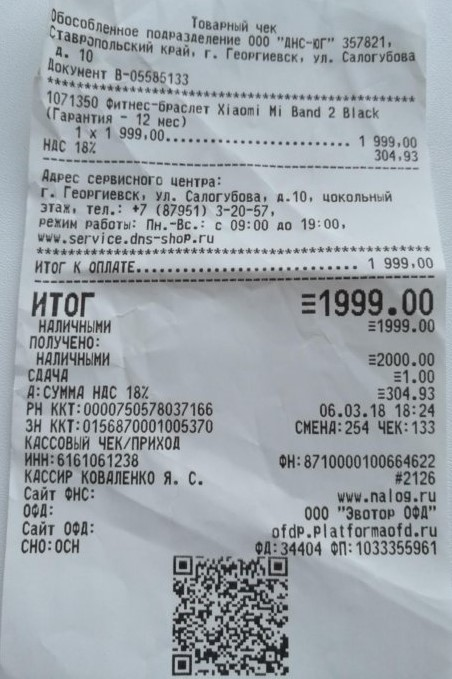

In [ ]:
Image.open('/content/drive/MyDrive/receipt_dataset/train/5ac640a72c593e6357602e75.jpg')